In [1]:
#Import standard python modules
import os.path
import sys
import xarray as xr
import numpy as np

#Determine local directory path:
local_path = os.path.abspath('') # os.path.dirname(os.path.abspath(__file__))
print(f"Local path appears to be {local_path}")

#set path to ADF lib:
lib_path = os.path.join(local_path,"lib")
print(f"Lib path appears to be {lib_path}")

#set path to ADF plotting scripts directory:
plotting_scripts_path = os.path.join(local_path, "scripts", "plotting")
print(plotting_scripts_path)

#Add paths to python path:
sys.path.append(lib_path)
sys.path.append(plotting_scripts_path)

#Import ADF diagnostics object:
from adf_diag import AdfDiag

Local path appears to be /glade/u/home/brianpm/Code/CAM_diagnostics
Lib path appears to be /glade/u/home/brianpm/Code/CAM_diagnostics/lib
/glade/u/home/brianpm/Code/CAM_diagnostics/scripts/plotting


In [2]:
from pathlib import Path
config_file = Path.home()/"drive_diagnostics"/"test_variable_prefs.yaml"

#Set path to config YAML file:
# config_fil = "/Users/brianpm/Code/scratch/CAM_diagnostics/config_user_module_example.yaml"

#Initialize ADF object:
adf = AdfDiag(config_file)

In [3]:
basic_info_dict = adf.read_config_var("diag_basic_info")
print(basic_info_dict)

testcase_dict = adf.read_config_var("diag_cam_climo")
print(testcase_dict)

baseline_dict = adf.read_config_var("diag_cam_baseline_climo")
print(baseline_dict)

{'compare_obs': False, 'create_html': True, 'obs_climo_loc': '/glade/work/brianpm/observations/climo_files', 'cam_regrid_loc': '/glade/scratch/brianpm/cam_diag_regrid_files', 'cam_overwrite_regrid': True, 'cam_diag_plot_loc': '/glade/scratch/brianpm/cam_diag_plots', 'use_defaults': True}
{'cam_case_name': 'b.e20.BHIST.f09_g17.20thC.297_05', 'calc_cam_climo': True, 'cam_overwrite_climo': False, 'cam_hist_loc': '/glade/p/cesm/ADF/b.e20.BHIST.f09_g17.20thC.297_05/', 'start_year': 1990, 'end_year': 1999, 'cam_ts_done': False, 'cam_ts_save': True, 'cam_overwrite_ts': False, 'cam_ts_loc': '/glade/scratch/brianpm/cam_diag_ts_files', 'cam_climo_loc': '/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05', 'cam_regrid_loc': '/glade/scratch/brianpm/cam_diag_regrid_files'}
{'calc_cam_climo': True, 'cam_overwrite_climo': True, 'cam_case_name': 'b.e20.BHIST.f09_g16.20thC.125.02', 'cam_hist_loc': '/glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02', 'cam_climo_loc': '/glade/s

In [8]:
## WHERE ARE THE CLIMO FILES:


# reference case:
list(Path(baseline_dict['cam_climo_loc']).glob(baseline_dict['cam_case_name']+"*"))


# test case(s):
list(Path(testcase_dict['cam_climo_loc']).glob(testcase_dict['cam_case_name']+"*"))

[PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_T_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_PSL_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_RELHUM_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_PRECC_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_LWCF_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_U_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_SWCF_climo.nc'),
 PosixPath('/glade/scratch/bria

In [4]:
#Case names:
reference_name = adf.get_baseline_info('cam_case_name', required=True)
case_names = adf.get_cam_info('cam_case_name', required=True)  # Loop over these


In [5]:
case_loc = adf.get_cam_info('cam_climo_loc', required=True)

In [6]:
base_loc = adf.get_baseline_info('cam_climo_loc', required=True)

In [25]:
# --- DERIVED VARIABLES --- 

def _pressure_from_hybrid(psfc, hya, hyb, p0=100000.):
    """Calculate pressure at the hybrid levels."""

    # p(k) = hya(k) * p0 + hyb(k) * psfc

    # This will be in Pa
    return hya * p0 + hyb * psfc


def vertical_average(fld, ps, acoef, bcoef):
    # get pressure field
    pres = _pressure_from_hybrid(ps, acoef, bcoef)
    # get del_pressure
    # return sum(fld * del_pressure) / sum(del_pressure)

    # integral of del_pressure turns out to be just the average of the square of the boundaries:
    # -- assume lev is a coordinate and is nominally in pressure units
    maxlev = pres['lev'].max().item()
    minlev = pres['lev'].min().item()
    dp_integrated = 0.5 * (pres.sel(lev=maxlev)**2 - pres.sel(lev=minlev)**2)

    levaxis = fld.dims.index('lev')  # fld needs to be a dataarray
    assert isinstance(levaxis, int), f'the axis called lev is not an integer: {levaxis}'

    fld_integrated = np.trapz(fld * pres, x=pres, axis=levaxis)
    return fld_integrated / dp_integrated




def find_landmask(adf, casename, location):
    # maybe it's in the climo files, but we might need to look in the history files:
    landfrac_fils = list(Path(location).glob(f"{casename}*_LANDFRAC_*.nc"))
    if landfrac_fils:
        return xr.open_dataset(landfrac_fils[0])['LANDFRAC']
    else:
        if casename in adf.get_cam_info('cam_case_name'):
            hloc = adf.get_cam_info('cam_hist_loc')
        else:
            hloc = adf.get_baseline_info('cam_hist_loc')
        hfils = Path(hloc).glob((f"*{casename}*.nc"))
        if not hfils:
            raise IOError(f"No history files in expected location: {hloc}")
        k = 0
        for h in hfils:
            dstmp = xr.open_dataset(h)
            if 'LANDFRAC' in dstmp:
                print(f"Good news, found LANDFRAC in file: {h}")
                return dstmp['LANDFRAC']
            else:
                k += 1
        else:
            raise IOError(f"Checked {k} files, but did not find LANDFRAC in any of them.")
            return None


def get_prect(casename, location):
    # look for prect first:
    fils = sorted(list(Path(location).glob(f"{casename}*_PRECT_*.nc")))
    if len(fils) == 0:
        print("Need to derive PRECT = PRECC + PRECL")
        fils1 = sorted(list(Path(location).glob(f"{casename}*_PRECC_*.nc")))
        fils2 = sorted(list(Path(location).glob(f"{casename}*_PRECL_*.nc")))
        if (len(fils1) == 0) or (len(fils2) == 0):
            raise IOError("Could not find PRECC or PRECL")
        else:
            if len(fils1) == 1:
                precc = xr.open_dataset(fils1[0])['PRECC']
                precl = xr.open_dataset(fils2[0])['PRECL']
                prect = precc + precl 
            else:
                print("Need to deal with mult-file case.")
    elif len(fils) > 1:
        prect = xr.open_mfdataset(fils)['PRECT'].load()  # do we ever expect climo files split into pieces? 
    else:
        prect = xr.open_dataset(fils[0])['PRECT']
    return prect


def get_tropical_land_precip(adf, casename, location):
    # get landfrac
    landfrac = find_landmask(adf, casename, location)
    if landfrac is None:
        raise ValueError("No landfrac returned")
    # get prect 
    prect = get_prect(casename, location)
    # mask to only keep land locations
    prect = xr.DataArray(np.where(landfrac >= .95, prect, np.nan),
                         dims=prect.dims,
                         coords=prect.coords,
                         attrs=prect.attrs)  # threshold could be 1
    return prect.sel(lat=slice(-30,30))


def get_tropical_ocean_precip(adf, casename, location):
    # get landfrac
    landfrac = find_landmask(adf, casename, location)
    if landfrac is None:
        raise ValueError("No landfrac returned")
    # get prect 
    prect = get_prect(casename, location)
    # mask to only keep ocean locations
    prect = xr.DataArray(np.where(landfrac <= 0, prect, np.nan),
                         dims=prect.dims,
                         coords=prect.coords,
                         attrs=prect.attrs)  
    return prect.sel(lat=slice(-30,30))


def get_u_at_plev(adf, casename, location):
    # parse input to know variable and pressure value
    # get variable
    # TODO: are variables saved on pressure levels, or do we need to interpolate?
    # return variable on plev
    pass

def get_virh(adf, casename, location):
    # get RELHUM climo
    # get PS
    # TODO: on pressure levels already?
    # TODO: RELHUM will have hyam, hybm? 
    # vertical_average(RELHUM, PS)
    pass

def get_vit(adf, casename, location):
    # get T climo
    # get PS
    # TODO: on pressure levels already?
    # TODO: T will have hyam, hybm? 
    # vertical_average(T, PS)
    pass

def get_derive_func(fld):
    funcs = {'TropicalLandPrecip': get_tropical_land_precip,
    'TropicalOceanPrecip': get_tropical_ocean_precip,
    'U300': get_u_at_plev,
    'VIRelativeHumidity': get_virh,
    'VITemperature': get_vit,
    }
    return funcs[fld]

def _retrieve(adfobj, variable, casename, location):
    v_to_derive = ['TropicalLandPrecip', 'TropicalOceanPrecip', 'EquatorialPacificStress', 
                'U300', 'ColumnRelativeHumidity', 'ColumnTemperature']
    if variable not in v_to_derive:
        fils = sorted(list(Path(location).glob(f"{casename}*_{variable}_*.nc")))
        print(fils)
        if len(fils) == 0:
            raise ValueError("something went wrong")
        elif len(fils) > 1:
            ds = xr.open_mfdataset(fils)  # do we ever expect climo files split into pieces? 
        else:
            ds = xr.open_dataset(fils[0])
    else:
        func = get_derive_func(variable)
        print(func)
        ds = func(adfobj, casename, location)
    return ds 


In [9]:
prect = _retrieve(adf, "TropicalOceanPrecip", reference_name, base_loc)

<function get_tropical_ocean_precip at 0x2b76b33aea60>
Good news, found LANDFRAC in file: /glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02.cam.h0.1996-01.nc
Need to derive PRECT = PRECC + PRECL


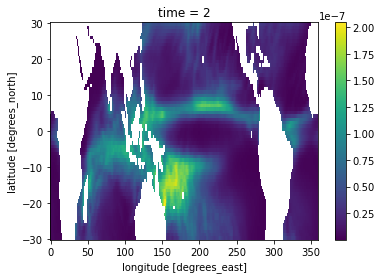

In [10]:
prect.isel(time=1).plot.pcolormesh()

In [11]:
temperature = _retrieve(adf, "T", reference_name, base_loc)

[PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02_T_climo.nc')]


In [30]:
temperature

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, lev: 32, time: 12, ilev: 33)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    hyam     (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm     (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9251 0.9512 0.9743 0.9926
    P0       (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05 1e+05
    hyai     (time, ilev) float64 0.002255 0.005032 0.01016 ... 0.003979 0.0 0.0
    hybi     (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9389 0.9636 0.9851 1.0
    PS       (time, lat, lon) float32 ...
    T        (time, lev, lat, lon) float32 ...

In [27]:
vatemp = vertical_average(temperature['T'], temperature['PS'], temperature['hyam'], temperature['hybm'])

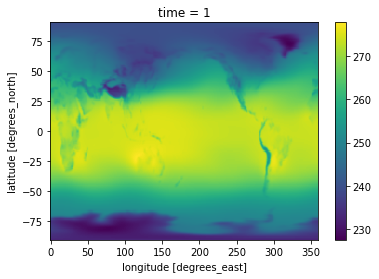

In [29]:
vatemp[0,:,:].plot.pcolormesh()

In [57]:
# adf.ge   'cam_hist_loc'
# dir(adf)
# diag_cam_climo:
  # cam_case_name:
  
  
adf.get_cam_info('cam_case_name')[0] == case_names[0]

True

In [55]:
adf.get_baseline_info('cam_case_name') == case_names[0]

False

In [56]:
adf.get_cam_info('cam_case_name')[0]

'b.e20.BHIST.f09_g17.20thC.297_05'

In [53]:
case_names[0]

'b.e20.BHIST.f09_g17.20thC.297_05'

In [58]:
adf.get_cam_info('cam_hist_loc')

['/glade/p/cesm/ADF/b.e20.BHIST.f09_g17.20thC.297_05/']

In [31]:
uwind = _retrieve(adf, "U", reference_name, base_loc)

[PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02_U_climo.nc')]


In [32]:
import geocat.comp as gc

In [35]:
u300 = gc.interp_hybrid_to_pressure(uwind['U'], uwind['PS'], uwind['hyam'], uwind['hybm'], new_levels=np.array([30000.0]), lev_dim='lev')

In [39]:
u300.squeeze(drop=True)

<xarray.DataArray '_vertical_remap-f39258875db323c69f147f83ff86b8c1' (time: 12, lat: 192, lon: 288)>
dask.array<getitem, shape=(12, 192, 288), dtype=float32, chunksize=(12, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [40]:
import pandas as pd

In [41]:
var_list = ['SLP', 'SWCF', 'LWCF', 
                'TropicalLandPrecip', 'TropicalOceanPrecip', 'EquatorialPacificStress', 
                'U300', 'ColumnRelativeHumidity', 'ColumnTemperature']

df_template = pd.DataFrame(index=var_list, columns=['case', 'corr', 'ratio', 'bias'])

In [49]:
df_template

,case,corr,ratio,bias
SLP,NaN,NaN,NaN,NaN
SWCF,NaN,NaN,NaN,NaN
LWCF,NaN,NaN,NaN,NaN
TropicalLandPrecip,NaN,NaN,NaN,NaN
TropicalOceanPrecip,NaN,NaN,NaN,NaN
EquatorialPacificStress,NaN,NaN,NaN,NaN
U300,mycasename,0.001,2.3,400.1
ColumnRelativeHumidity,NaN,NaN,NaN,NaN
ColumnTemperature,NaN,NaN,NaN,NaN


In [46]:
adf.get_cam_info('cam_climo_loc', required=True)

['/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05']

In [48]:
df_template.loc['U300'] = ['mycasename', 0.001, 2.3, 400.1]

In [50]:
df_template.loc['SLP'] = ('mycasename2', 0.999, 0.3, 1.1)
df_template

,case,corr,ratio,bias
SLP,mycasename2,0.999,0.3,1.1
SWCF,NaN,NaN,NaN,NaN
LWCF,NaN,NaN,NaN,NaN
TropicalLandPrecip,NaN,NaN,NaN,NaN
TropicalOceanPrecip,NaN,NaN,NaN,NaN
EquatorialPacificStress,NaN,NaN,NaN,NaN
U300,mycasename,0.001,2.3,400.1
ColumnRelativeHumidity,NaN,NaN,NaN,NaN
ColumnTemperature,NaN,NaN,NaN,NaN
